In [1]:
from dotenv import load_dotenv
from datasets import load_dataset
from src.embedder.dense import Embedder
from sentence_transformers import losses
from src.datasource.dense import DenseDatasource
from src.utils import train, evaluate_model, load_test_data

/Users/mikhailkoutun/PycharmProjects/searchEngine/.venv/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
queries_dataset = load_dataset("CoIR-Retrieval/cosqa", "queries")["queries"]
corpus_dataset = load_dataset("CoIR-Retrieval/cosqa", "corpus")["corpus"]
default_dataset = load_dataset("CoIR-Retrieval/cosqa", "default")
test_corpus = [function for partition, function in zip(corpus_dataset["partition"], corpus_dataset["text"]) if
               partition == "test"]
test_queries = [query for partition, query in zip(queries_dataset["partition"], queries_dataset["text"]) if
                partition == "test"]

In [3]:
model = Embedder("sentence-transformers/all-MiniLM-L6-v2", 384)
loss = losses.MultipleNegativesRankingLoss
trainer = train(model, loss, default_dataset, corpus_dataset, queries_dataset, 5, True)

/Users/mikhailkoutun/PycharmProjects/searchEngine/.venv/lib/python3.13/site-packages/torch/utils/data/dataloader.py:684: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Step,Training Loss
500,0.083600
1000,0.046200
1500,0.037600
2000,0.028800
2500,0.026400


/Users/mikhailkoutun/PycharmProjects/searchEngine/.venv/lib/python3.13/site-packages/torch/utils/data/dataloader.py:684: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)
/Users/mikhailkoutun/PycharmProjects/searchEngine/.venv/lib/python3.13/site-packages/torch/utils/data/dataloader.py:684: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)
/Users/mikhailkoutun/PycharmProjects/searchEngine/.venv/lib/python3.13/site-packages/torch/utils/data/dataloader.py:684: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)
/Users/mikhailkoutun/PycharmProjects/searchEngine/.venv/lib/python3.13/site-packages/torch/utils/data/dataloader.py:684: UserWarning: 'pin_memory' argument is set as true but not supported on MPS 

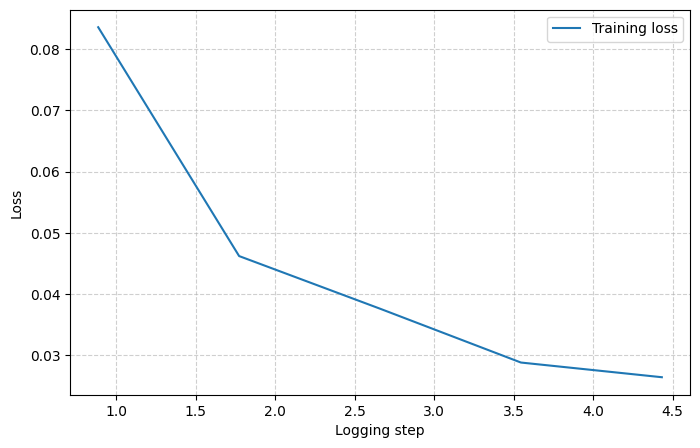

In [4]:
train_losses = [
    log["loss"]
    for log in trainer.state.log_history
    if "loss" in log and "epoch" in log
]

epochs = [
    log["epoch"]
    for log in trainer.state.log_history
    if "loss" in log and "epoch" in log
]


import matplotlib.pyplot as plt
plt.figure(figsize=(8, 5))
plt.plot(epochs, train_losses, label="Training loss")
plt.xlabel("Logging step")
plt.ylabel("Loss")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.6)
plt.show()

In [5]:
load_dotenv()

models = [
          Embedder("Qwen/Qwen3-Embedding-0.6B", 1024),
          Embedder("sentence-transformers/all-MiniLM-L6-v2", 384),
          Embedder("sentence-transformers/all-MiniLM-L6-v2", 384, load_tuned=True)
          ]

for model in models:
    db = DenseDatasource(model)
    load_test_data(db, "code-test", test_corpus, True)
    print(model.model_name, "Tuned" if model.is_tuned else "")
    recall, mrr, ndcg = evaluate_model(db, "code-test", test_queries, test_corpus)
    print("Recall:", recall)
    print("MRR:", mrr)
    print("NDCG:", ndcg)


Qwen/Qwen3-Embedding-0.6B 
Recall: 1.0
MRR: 0.8764857142857143
NDCG: 0.905437919527317
sentence-transformers/all-MiniLM-L6-v2 
Recall: 1.0
MRR: 0.8093507936507935
NDCG: 0.8511737977500772
sentence-transformers/all-MiniLM-L6-v2 Tuned
Recall: 1.0
MRR: 0.8775928571428572
NDCG: 0.907142591321894
